In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.integrate as spint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
hp.nside2npix(512)

3145728

# Notes/Questions
want full Haslam 408 sky map in mollweide projection through healpy, may need to look at header info in more detail to get healpy specs. May also need to pull up old PHYS321 project to check healpy usage. 

NSIDE = 512 for the Haslam map

Haslam map comes in mK, divide by 1000 to get K

How to go from K to intensity for equation?

standard angle notation here is (lon, lat) in degrees, convert to radians only to compute the gaussian


Ghosh et al paper as sanity check

# Using cgs units in this notebook

In [3]:
#helper function that computes the opposite direction angle from the angle entered
def opposite(point): #takes latitude and longitude in degrees point = [lat, lon]
    return(((point[0]+180)%360, -1*point[1]))

In [4]:
#gaussian normalized to the 2D sky for use as f in computing the angular integral
def gaussian(theta, two_sigma_d):
    return np.exp(-0.5*(theta**2)/(two_sigma_d**2))/(2*np.pi*(two_sigma_d**2))

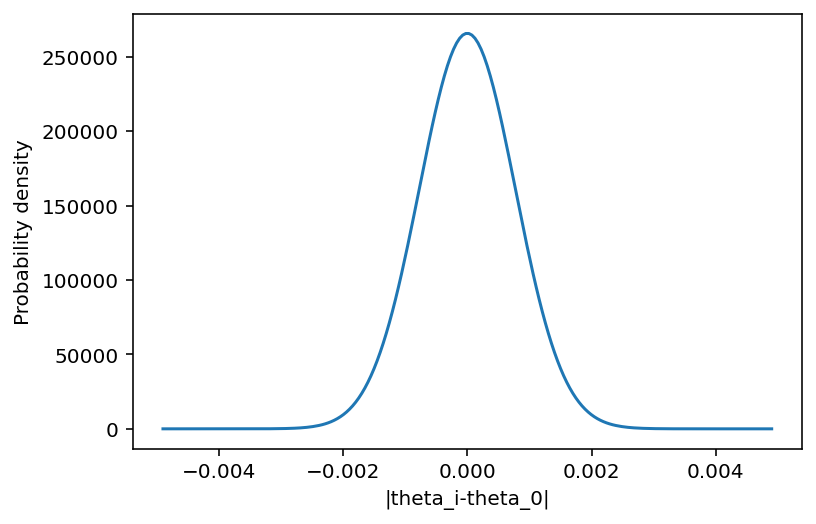

In [5]:
# cell to look at the gaussian profile to determine how large to make it in calcualtion
num_sigma = 7
two_sigma_d = 2*116000/299792458 # in units where c=1 the standard deviation of f
x_vals = np.linspace(-0.0007*num_sigma,0.0007*num_sigma,200)
plt.plot(x_vals, gaussian(x_vals, two_sigma_d))
plt.xlabel("|theta_i-theta_0|")
plt.ylabel("Probability density");
gaussian(-0.0007*num_sigma, two_sigma_d);

In [6]:
#make a function that converts from sky temperature to specific intensity
def temp_to_intensity(T, freq):
    return((2*freq**2 * 1.380649e-16 *T)/((2.9979245800e10)**2))

In [7]:
def intensity_to_temp(I, freq):
    return((I*(2.9979245800e10)**2)/(2 * freq**2 * 1.380649e-16))

# Make NSIDE flexible DM density map generator (does column integrals of NFW profile, will be hella algebra probably to get line integrals working) - use vector algebra to get R from the galactic coords and dm depth

In [8]:
#NFW profile DM function from Yitian's notebook
def NFW_profile(r): #g/cm^3(kpc)
    return 1/( (r/16)*(1+r/16)**2 ) * 9.653726724487642e-25 * 3.08568e21

In [9]:
#function that takes Galactic R, lon, lat and returns distance to galactic center
def r(Gr, Glon, Glat): #takes Gr in kpc and Glon, Glat in degrees
    RS = 8.22 #kpc from galactic center to sun
    Glon_rad = np.radians(Glon)
    Glat_rad = np.radians(Glat)
    Dx = RS - Gr*np.cos(Glat_rad)*np.cos(Glon_rad)
    Dy = Gr*np.cos(Glat_rad)*np.sin(Glon_rad)
    Dz = Gr*np.sin(Glat_rad)
    return(np.sqrt(Dx**2 + Dy**2 + Dz**2))

In [10]:
#function to serve as integrand in column integral
def NFW_integrand(Gr, Glon, Glat):
    return( NFW_profile(r(Gr, Glon, Glat)) )

#I think that we won't need to worry about divergence that happens at galactic center since the healpix pixel's
#center for NSIDE=512 in this direction is actually slightly off from pointing right at the center of the galaxy

In [11]:
#function that column integrates along a line of sight given by galactic latitiude in degrees
#glon & glat are galactic lon and lat INF is maximum distance we integrate to
def DM_density(Glon, Glat, INF): #Yitian uses INF = 1000kpc
    return(spint.quad(NFW_integrand, 0, INF, args=(Glon, Glat))[0])


In [18]:
DM_density(83.94977614256821,0,1.715) #agrees with Yitian's DM density function

0.004367058798740681

In [19]:
DM_density(0,83.94977614256821,1.715)

0.004367058798740681

In [20]:
DM_density(0,0,1.715)

0.005253028577993097

In [21]:
for i in [10,100,1000,10000,100000,1000000]:
    print(DM_density(0,5,i)) #appears to converge nicely at INF = 1000

0.18311195017872373
0.24705284362655547
0.24763010695176935
0.24763611675569067
0.24763617712192076
0.24542833530069358


/var/folders/ng/f17v0fzn0wv_htkn4y8vzxx40000gn/T/ipykernel_44776/4074185744.py:4: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return(spint.quad(NFW_integrand, 0, INF, args=(Glon, Glat))[0])


In [16]:
%%time
#making map of DM density over the sky so I can see how it looks
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
DM_map = np.zeros(NPIX)
INF = 1000

#looping over blank map and computing integral at each step
for i in range(len(DM_map)):
    Glon, Glat = hp.pix2ang(NSIDE,i,lonlat=True)
    DM_map[i] = DM_density(Glon, Glat, INF)

#plotting map
hp.mollview(DM_map, title="DM density", unit='g/cm^2')
np.savez("DM_map_2", DM_map)

KeyboardInterrupt: 

# need to make a DM density map that I can pass to I_g so that it runs faster, will run it on NSIDE = 512 when I am done for the day

In [17]:
DM_map[785521]

0.0

In [22]:
?hp.pix2ang

In [50]:
#main function that computes gegenschein for a given pixel

def I_g(sky_data, DM_map, pix, NSIDE, two_sigma_d, n_sigma, g_ayy):
    #finding lonlat angular coords of points opposite to pix
    I_g_ang = hp.pix2ang(NSIDE, pix, lonlat=True)
    I_g_opposite_ang = opposite(I_g_ang)
    
    
    #CODE THAT TAKES THE GAUSSIAN OVER A DISK
    '''
    #finding disk of points within n*sigma of the opposite angle
    vec_0 = hp.ang2vec(I_g_opposite_ang[0], I_g_opposite_ang[1], lonlat=True)
    disk_points = hp.query_disc(NSIDE, vec=vec_0, radius = two_sigma_d*n_sigma, inclusive = True)
    
    #now computing angular integral weighted by the gaussian function
    
    disk_sky = sky_data[disk_points] #sky map values from disk array
    vec_i = np.transpose(hp.pix2vec(NSIDE, disk_points)) #normalized vectors pointing at every point in the disk
    #finding angle between vec_0(opposite to pix) and each point on disk
    ang_i_rad = np.arccos(np.clip(np.sum(vec_0*vec_i,axis=1),0,1)) #taking dot products with vec_0, taking arccos to get angles
    gaussian_val = gaussian(ang_i_rad, two_sigma_d) #running the angles through the normalized gaussian
    
    
    
    #multiplying f(theta_i) by intensities and performing sum & weighting pix area
    integral = np.sum(disk_sky*gaussian_val)*hp.nside2pixarea(NSIDE)
    '''
    
    #code that takes gegenschein to be a perfect mirror i.e. gaussian is contained in one pixel and not resolved
    vec_0 = hp.ang2vec(I_g_opposite_ang[0], I_g_opposite_ang[1], lonlat=True)
    disk_points = hp.query_disc(NSIDE, vec=vec_0, radius = 0.00000001, inclusive = True)
    source = sky_data[disk_points]
    
    #NEED TO MULTIPLY BY DM DENSITY IN DIRECTION GIVEN BY PIX
    
    integral = 6.62607015e-27*(1/(2*np.pi))*((2.9979245800e10)**4)*((g_ayy**2)/16)*source*DM_map[pix]
    
    
    return(integral[0])

In [46]:
I_g(spec_intensity_map, DM_map, 48000, 512, two_sigma_d, n_sigma, g_ayy)

2.7329333e-21

In [73]:
#code that tests against Yitian's test case by taking the ratio of source and gegenschein specific intensities
pix=1000000
I_g_ang = hp.pix2ang(NSIDE, pix, lonlat=True)
I_g_opposite_ang = opposite(I_g_ang)
opp_pix = hp.ang2pix(512, I_g_opposite_ang[0], I_g_opposite_ang[1], lonlat=True)
I_source = spec_intensity_map[opp_pix]
I_g_val = I_g(spec_intensity_map, DM_map, pix, 512, two_sigma_d, n_sigma, g_ayy)
I_g_specific=I_g_val / (408e6 * (2*116000 / 299792458))
print(I_g_specific/I_source)

1.0489194752135733e-08


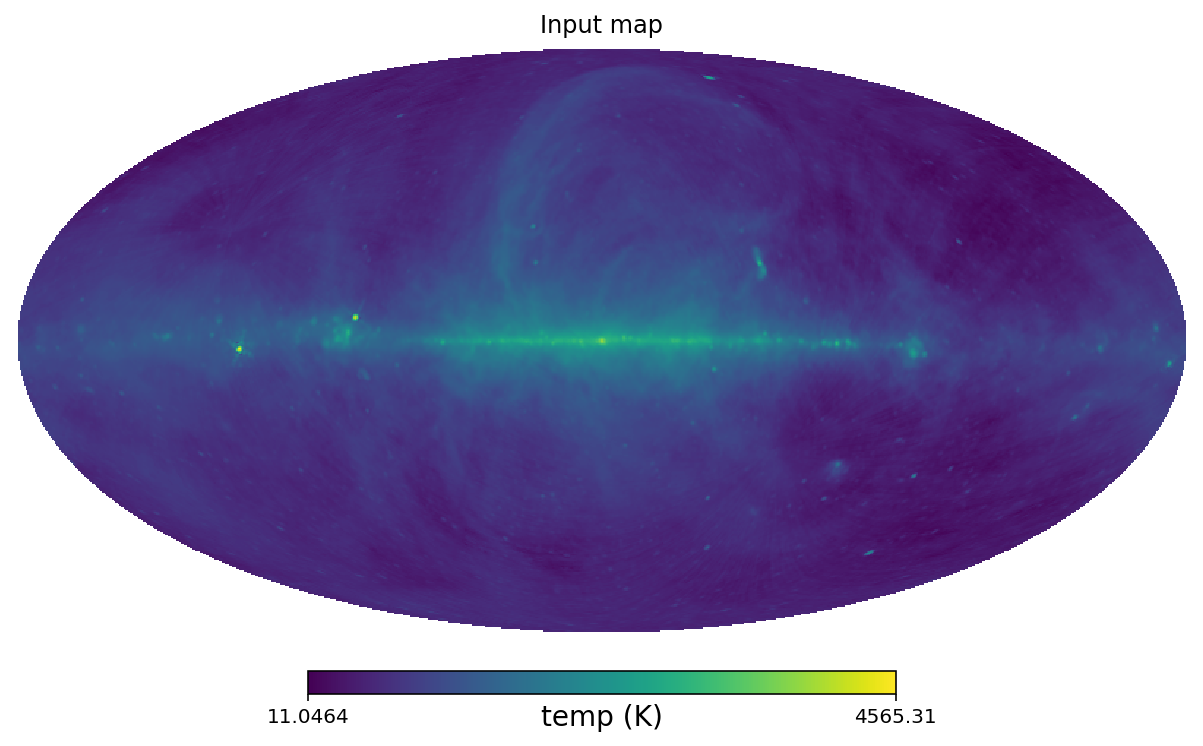

In [18]:
#loading in map data
map_raw_address = '/Users/harpersewalls/Desktop/SURA/Haslam_static_map/lambda_haslam408_nofilt.fits'
map_raw = hp.read_map(map_raw_address)/1000 #divide by 1000 to convert mK to K
hp.mollview(map_raw,norm='log',title="Input map", unit='temp (K)')
#map with filtering and string sources removed



CPU times: user 1min 34s, sys: 384 ms, total: 1min 34s
Wall time: 1min 34s


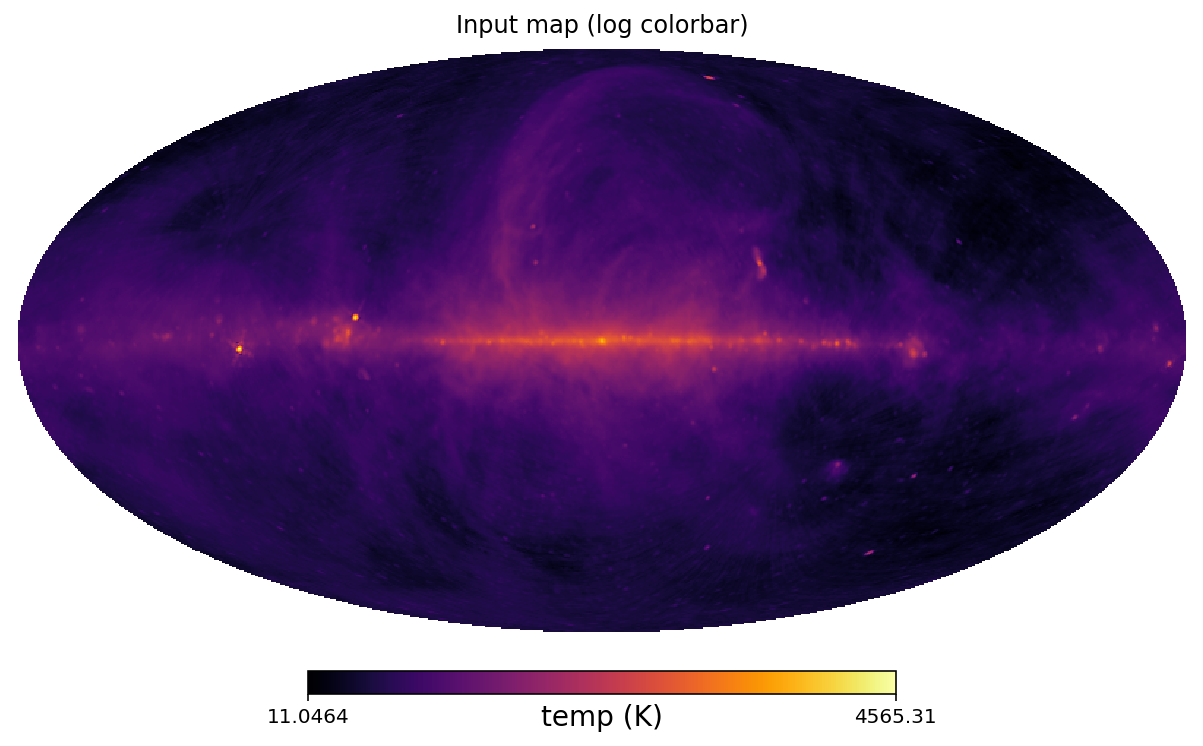

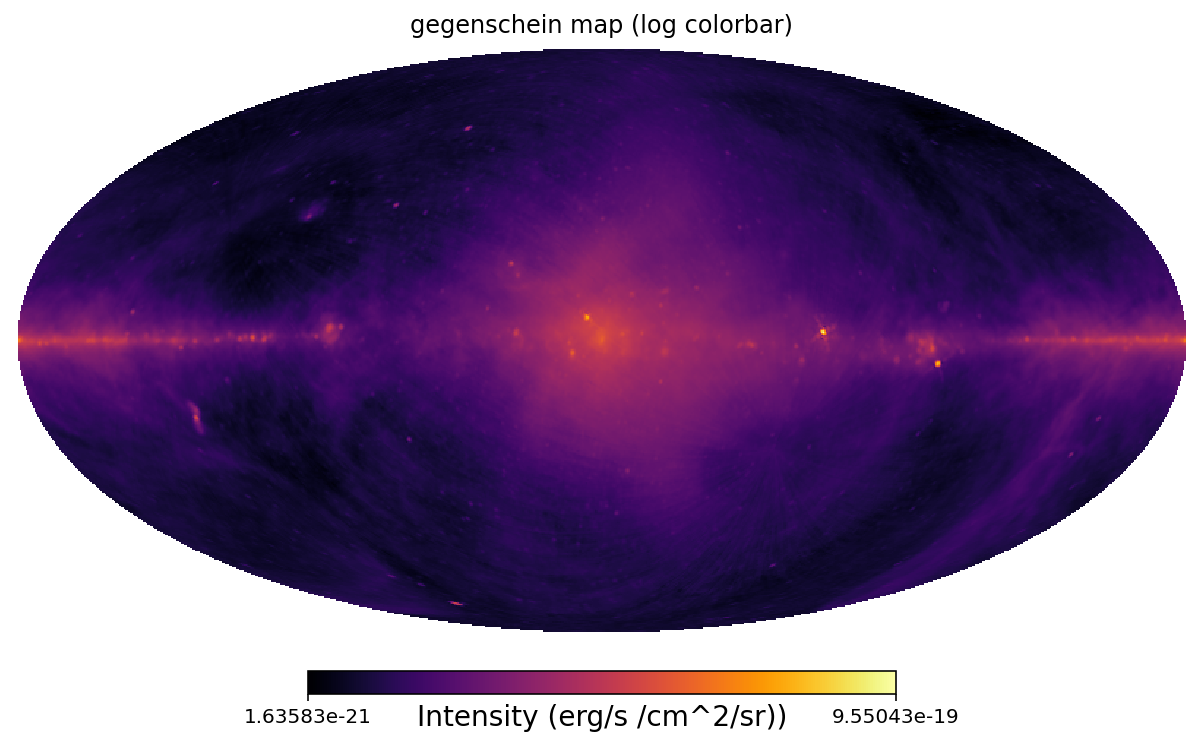

In [74]:
%%time
#main cell where we load in data and call main function

#loading in map data
map_raw_address = '/Users/harpersewalls/Desktop/SURA/Haslam_static_map/lambda_haslam408_nofilt.fits'
map_raw = hp.read_map(map_raw_address)/1000 #divide by 1000 to convert mK to K
hp.mollview(map_raw,norm='log',title="Input map (log colorbar)", unit='temp (K)', cmap='inferno')
#map with filtering and string sources removed

#defining parameters
#physical parameters
g_ayy = 4.1194e-8 #(erg^-1) axion photon coupling constant in cgs experimental bound originally 6.6*10^-11 GeV^-1
two_sigma_d = 2*116000/299792458 # in units where c=1 the standard deviation of f
freq = 408e6 #radio frequency in Hz that we are looking at in map

#simulation parameters
NSIDE = 512 #HEALPix parameter on how data is encoded
n_sigma = 4 #num of standard deviations to take for computing gaussian blurring

#converting map from temp to specific intensity and plotting
spec_intensity_map = temp_to_intensity(map_raw, freq)
#hp.mollview(spec_intensity_map,norm='log',title="Input map", unit='Specific Intensity')

#loading in precalculated DM density map
DM_map = np.load("sky_maps/DM_map.npz")['arr_0']

#making sky map of I_g
I_g_map = np.zeros(hp.nside2npix(NSIDE))

for i in range(len(I_g_map)):
    I_g_map[i] = I_g(spec_intensity_map, DM_map, i, NSIDE, two_sigma_d, n_sigma, g_ayy)

hp.mollview(I_g_map, title="gegenschein map (log colorbar)", norm = 'log', unit='Intensity (erg/s /cm^2/sr))', cmap='inferno')


# convert the map back into K for final product
# determine what unit problems I am having, in which particular equations
# temp to intensity equation, equation 12, what else? map out mathematical pipeline

In [71]:
np.savez("gegenschein_goodunits",I_g_map)

In [ ]:
#loading in maps
blur_I_g = np.load("sky_maps/extra_blurred_map_badunits.npz")['arr_0'] #blurred with sigma_d = 0.5%c
normal_I_g = np.load("sky_maps/gegenschein_map_badunits.npz")['arr_0'] #blurred with sigma_d = 116km/sa

In [ ]:
#maps with exaggerated blurring
hp.mollview(spec_intensity_map,norm='log',title="Input map", unit='Specific Intensity')
hp.mollview(normal_I_g,norm='log',title="gegenschein map", unit='Specific Intensity')
hp.mollview(blur_I_g, title="extra blurred gegenschein map", norm="log")

In [ ]:
opposite((256.20, -5.75))

In [ ]:
#maps with exaggerated blurring
point = (76.2,5.75)
opp_point = opposite(point)
print(opp_point)

hp.gnomview(spec_intensity_map, rot=point, title="Input map",reso=100, xsize=100, norm='log')
hp.gnomview(normal_I_g, rot=opp_point, title="gegenschein map", reso=100, xsize=100, norm="log")
hp.gnomview(blur_I_g, rot=opp_point, title="extra blurred gegenschein map", reso=100, xsize=100, norm="log")

In [ ]:
%%time
#loading in and gegenscheining the hi res Haslam map with NSIDE=2048
#main cell where we load in data and call main function

#loading in map data
map_raw_address = '/Users/harpersewalls/Desktop/SURA/Haslam_static_map/haslam408_dsds_Remazeilles2014_ns2048.fits'
map_raw = hp.read_map(map_raw_address)/1000 #divide by 1000 to convert mK to K
hp.mollview(map_raw,norm='log',title="Input map", unit='temp (K)')
#map with filtering and string sources removed


#defining parameters
#physical parameters
g_ayy = 10**-10 #axion photon coupling constant
two_sigma_d = 2*116000/299792458 # in units where c=1 the standard deviation of f
#two_sigma_d = 0.01
freq = 408*10**6 #radio frequency in Hz that we are looking at in map

#simulation parameters
NSIDE = 2048 #HEALPix parameter on how data is encoded

n_sigma = 4
INF = 1000 #Depth of DM density integration in kpc, should be much larger than DM halo

#converting map from temp to specific intensity and plotting
spec_intensity_map = temp_to_intensity(map_raw, freq)
hp.mollview(spec_intensity_map,norm='log',title="Input map", unit='Specific Intensity')


#making sky map of I_g
I_g_map = np.zeros(hp.nside2npix(NSIDE))

for i in range(len(I_g_map)):
    if i%1000000 == 0:
        print(i)
    I_g_map[i] = I_g(spec_intensity_map, i, NSIDE, two_sigma_d, n_sigma, g_ayy, INF)

hp.mollview(I_g_map, title="gegenschein map", norm='log')

np.savez("small_scale_gegenschein_map", I_g_map)

In [ ]:
#loading in map
hi_rez_I_g = np.load("sky_maps/small_scale_gegenschein_map_badunits.npz")['arr_0'] #hi rez with NSIDE = 2048

In [ ]:
#maps with exaggerated blurring
point = (90,20)
opp_point = opposite(point)
print(opp_point)
hp.gnomview(spec_intensity_map, rot=point, title="Input map",reso=20, xsize=50, norm='hist')
hp.gnomview(hi_rez_I_g, rot=opp_point, title="gegenschein map", reso=20, xsize=50, norm="hist")

# remember to save the output array as an npz so you have the map for future use
# zoom in and look for arcminute blurring

In [ ]:
%%time
I_g(spec_intensity_map, pix, NSIDE, two_sigma_d, n_sigma, g_ayy, INF)

In [ ]:
hp.ang2pix(512, 0, 0, lonlat=True)

In [ ]:
map_raw[2139712]

In [ ]:
?hp.ang2pix

In [ ]:
?np.dot

In [ ]:
0.90730286*0.90867106

In [ ]:
0.38362641*0.3813837

In [ ]:
np.arccos(1)

In [ ]:
?hp.nside2pixarea